In [3]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline 
import os 
import seaborn as sns 
from scipy.special import softmax 
from scipy.stats import ttest_rel
import pandas as pd 

In [4]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-127', 'sub-279', 
'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG','V1']

def permutation_pvalue(x,y):
    orig=np.abs(np.median(x-y))
    diffs=x-y
    perms=[]
    for _ in range(10000):
        perms.append(np.median(diffs*np.random.choice([-1,1],size=len(diffs),replace=True))) 
    if np.sum(np.abs(perms)>=orig)==0:
        return 1.0/10000.0
    else:
        return np.sum(np.abs(perms)>=orig)/10000.0

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig] 
rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG','V1']


def get_results(postfix,rep_name):
    results=[]
    dataset=['black','slumlordreach']
    normalize_isc=True
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            if len(postfix)==0:
                results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results.npy"))
            else:
                results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_"+postfix+".npy"))
            if postfix=='silent_residual':
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc_regress_silent/"+sub+'.npy'))
            elif postfix=='full_residual':
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc_regress_nuisance/"+sub+'.npy'))
            else:
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
            noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
            results_sub=np.zeros((22,))
            noise_sub=np.zeros((22,))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append((results_sub/noise_sub)*100.0)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 

In [ ]:
def get_results(postfix,rep_name):
    results=[]
    dataset=['black','slumlordreach']
    normalize_isc=True
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            if len(postfix)==0:
                results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results.npy"))
            else:
                results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_"+postfix+".npy"))
            if postfix=='silent_residual':
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc_regress_silent/"+sub+'.npy'))
            elif postfix=='full_residual':
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc_regress_nuisance/"+sub+'.npy'))
            else:
                noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
            noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
            results_sub=np.zeros((22,))
            noise_sub=np.zeros((22,))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean()
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append((results_sub/noise_sub)*100.0)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 

In [8]:
def get_results_full(rep_name,alphas=False):
    results=[]
    dataset=['black','slumlordreach']
    normalize_isc=True
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI_new.npy')
        for sub in subs:
            #results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            #noise_ceiling_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
            if alphas:
                results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results_alphas2.npy")
                normalize_isc=False 
            else: 
                results_sub_parcels=np.arctanh(np.load(result_dir+sub+"_parcelwise_results_banded_ridge_full2.npy"))
            noise_ceiling_parcels=np.arctanh(np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy'))
            results_sub_parcels[np.isnan(results_sub_parcels)]=0.0
            noise_ceiling_parcels[np.isnan(noise_ceiling_parcels)]=0.0
            results_sub=np.zeros((22,4))
            noise_sub=np.zeros((22,4))
            
            for roi in range(22):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean(axis=0) 
                noise_sub[roi]=noise_ceiling_parcels[np.where(roi_mapping==roi+1)].mean(axis=0)
            #results_story.append(-1*np.log(results_sub/noise_sub))
            if normalize_isc:
                r=(results_sub/noise_sub)*100.0 
                r[r>100.0]=100.0
                results_story.append((results_sub/noise_sub)*100.0)
            else:
                results_story.append((results_sub))
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    results=np.concatenate(results,axis=0)
    results[np.isnan(results)]=0.0
    return results 

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Linguistic Features')

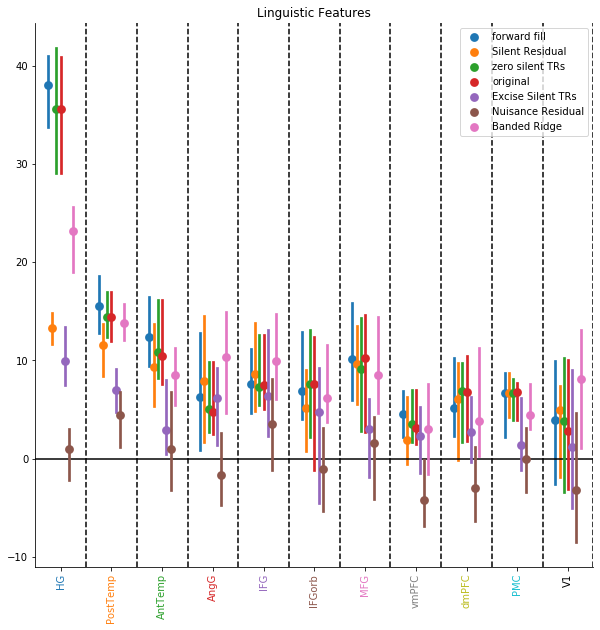

In [3]:
results=get_results('ffill','encoding-ling_features')
rep_results=[get_results('ffill','encoding-ling_features'),get_results('silent_residual','encoding-ling_features'),get_results('zero_silent','encoding-ling_features'),get_results('','encoding-ling_features'),get_results('no_silent_TR','encoding-ling_features'),get_results('full_residual','encoding-ling_features'),get_results('banded_ridge','encoding-ling_features')]
rep_names=['forward fill','Silent Residual','zero silent TRs','original','Excise Silent TRs','Nuisance Residual','Banded Ridge']
#rep_results=[rep_results[i] for i in [0,1,2,5,6]]
#rep_names=[rep_names[i] for i in [0,1,2,5,6]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Linguistic Features")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Layer 10 activations')

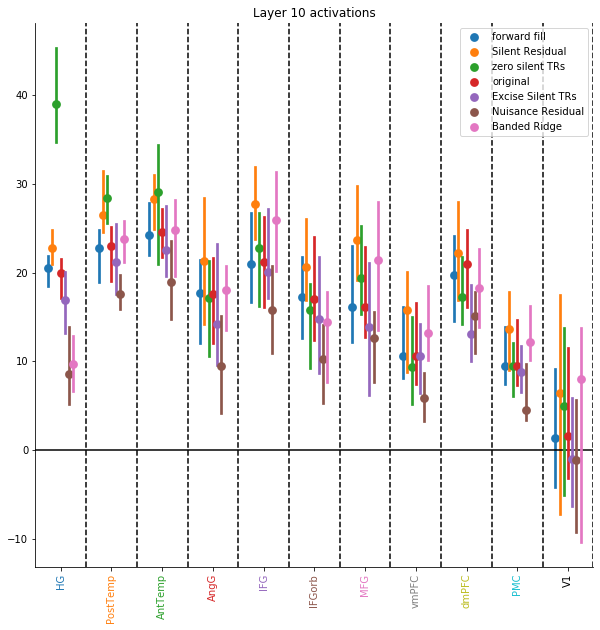

In [4]:
rep_results=[get_results('ffill','encoding-layer_9_activations'),get_results('silent_residual','encoding-layer_9_activations'),get_results('zero_silent','encoding-layer_9_activations'),get_results('','encoding-layer_9_activations'),get_results('no_silent_TR','encoding-layer_9_activations'),get_results('full_residual','encoding-layer_9_activations'),get_results('banded_ridge','encoding-layer_9_activations')]
rep_names=['forward fill','Silent Residual','zero silent TRs','original','Excise Silent TRs','Nuisance Residual','Banded Ridge']
#rep_results=[rep_results[i] for i in [0,1,2,5,6]]
#rep_names=[rep_names[i] for i in [0,1,2,5,6]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Layer 10 activations")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Linguistic Features')

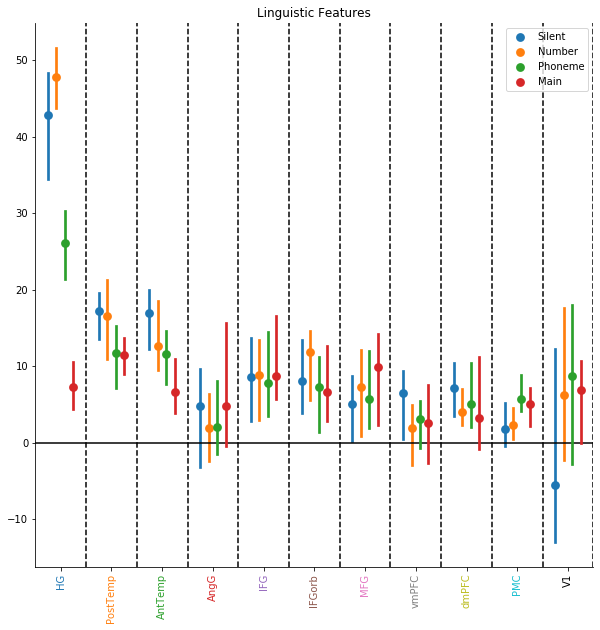

In [13]:
results=get_results_full('encoding-ling_features')
rep_names=['Silent','Number','Phoneme','Main']

rep_results=[results[:,:,0],results[:,:,1],results[:,:,2],results[:,:,3]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Linguistic Features")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Layer 10 Activations')

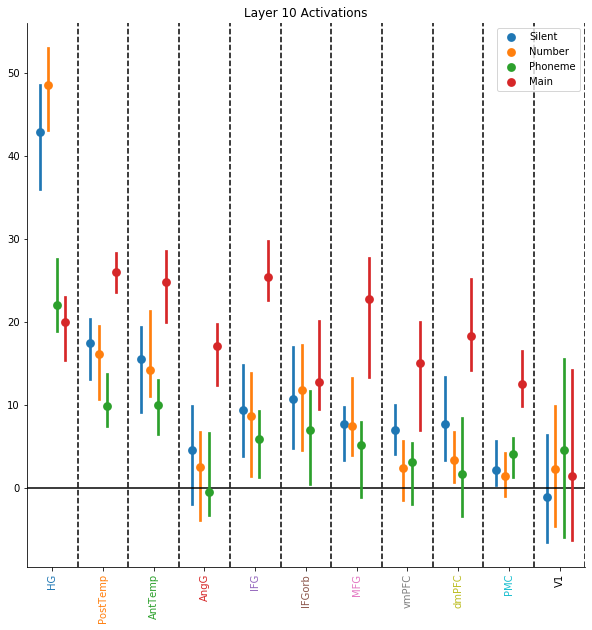

In [14]:
results=get_results_full('encoding-layer_9_activations')
rep_names=['Silent','Number','Phoneme','Main']
rep_results=[results[:,:,0],results[:,:,1],results[:,:,2],results[:,:,3]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Layer 10 Activations")

Text(0.5, 1.0, 'Linguistic Features')

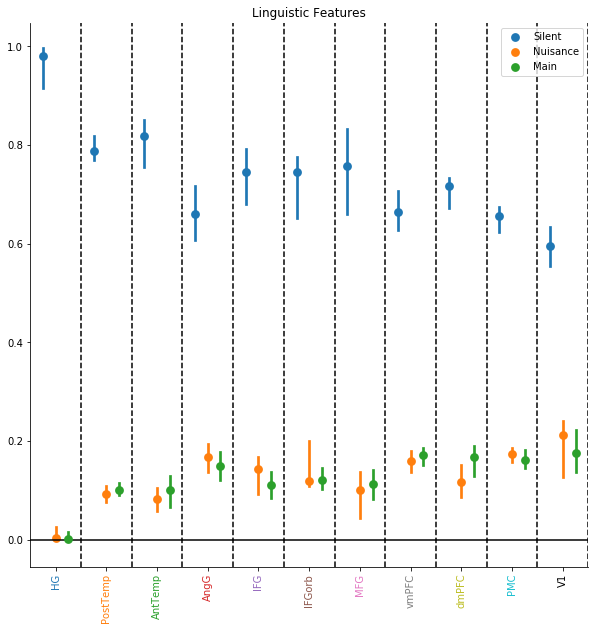

In [19]:
results=get_results_full('encoding-ling_features',alphas=True)
rep_names=['Silent','Nuisance','Main']
rep_results=[results[:,:,0],results[:,:,1],results[:,:,2]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Linguistic Features")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Linguistic Features')

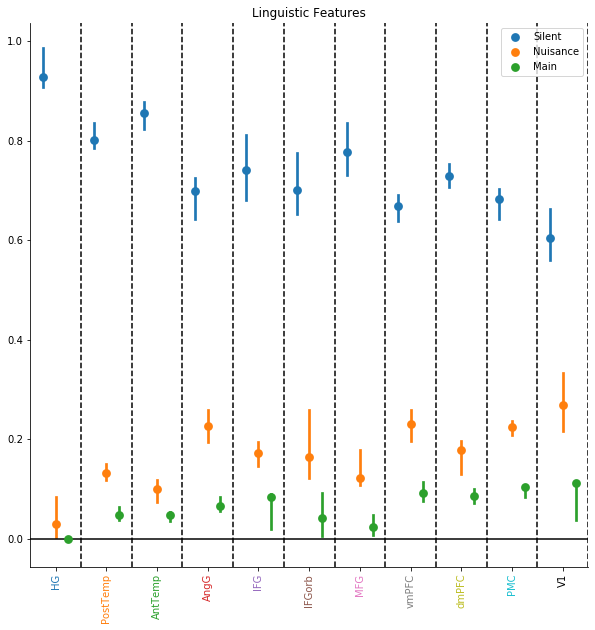

In [20]:
results=get_results_full('encoding-layer_9_activations',alphas=True)
rep_names=['Silent','Nuisance','Main']
rep_results=[results[:,:,0],results[:,:,1],results[:,:,2]]
performance=[]
roi=[]
rep_name=[]
for i in range(62):
    for j in range(11):
        for k in range(len(rep_names)):
            performance.append(rep_results[k][i,j])
            roi.append(rois[j])
            rep_name.append(rep_names[k])
df=pd.DataFrame(dict(performance=performance,roi=roi,rep=rep_name))
plt.figure(figsize=(10,10))
pal=sns.mpl_palette('tab10',n_colors=10)
sns.pointplot(data=df,x='roi',y='performance',hue='rep',dodge=0.5,join=False,ci=95,n_boot=10000,zorder=2,alpha=0.5,order=['HG','PostTemp','AntTemp','AngG','IFG',
'IFGorb','MFG','vmPFC','dmPFC','PMC','V1'],capsize=0,estimator=np.median)
plt.xticks(rotation=90)
plt.axhline(y=0,color='black')
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(rep_names)], labels[:])
sns.despine(top=True,right=True,left=False,bottom=False)
my_colors=['C'+str(i) for i in range(10)]
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)
plt.xlabel("")
plt.ylabel("")
for i in range(11):
    plt.axvline(x=i+0.5,color='black',linestyle='--')
plt.title("Linguistic Features")

In [12]:
16*16*100

25600